In [1]:
import matplotlib.pyplot as plt
import itertools
import hoomd
import math

import xarray as xr
import numpy
import gsd.hoomd
import sphere_fres as sf


In [2]:
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='random.gsd')

#simulation parameters
initial_kT = 0.0001

In [3]:
#The terrible things done to the data set

ds_disk = xr.open_dataset("mt_full.nc")
temp1 = ds_disk.to_array()
tarr = temp1.data
tarr = numpy.squeeze(tarr)
tarrt = numpy.reshape(tarr,(11*11*11*2*2*2))
patch_param_array = numpy.append(tarrt,initial_kT)

In [4]:
mc = hoomd.hpmc.integrate.Sphere(default_d=2, default_a=0.2)
mc.shape['A'] = dict(diameter=12, orientable=True)
sim.operations.integrator = mc


In [5]:
patch_code = f"""

return -31000;

"""


In [6]:
patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut=10,
                                                    code=patch_code,
                                                    param_array=patch_param_array)

mc.pair_potential = patch_potential
sim.run(0000)
print(patch_potential.energy)

-1209000.0


In [7]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=[
    'energy',
])
logger[('kT',)] = (lambda: patch_potential.param_array[10648], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(50),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)


In [8]:
sim.run(30000)


In [9]:
gsd_writer.flush()

data = gsd.hoomd.read_log('log.gsd')
step = data['configuration/step']

beta_potential_energy = data['log/hpmc/pair/user/CPPPotential/energy']
kT = data['log/kT']
potential_energy = beta_potential_energy * kT


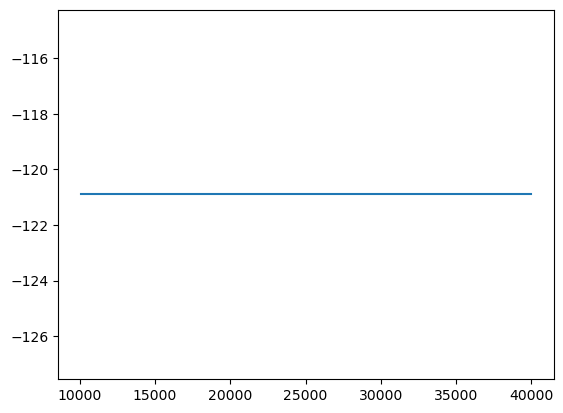

In [10]:
plt.figure(1)
plt.plot(step,potential_energy)

In [11]:
with sim.state.cpu_local_snapshot as sn:
    #print(sn.particles.position)
    N_particles = max(sn.particles.tag)
    distlog = numpy.array([])
    for i in range(N_particles):
        for j in range(i+1,N_particles):
            displacement = sn.particles.position[i,:]- sn.particles.position[j,:]
            distlog = numpy.append(distlog,math.sqrt(numpy.dot(displacement, displacement)))
    dist =sn.particles.position[0,:]- sn.particles.position[1,:]
    #print(math.sqrt(numpy.dot(dist, dist)))

Text(0.5, 0, 'Distance / 10^(-10)m')

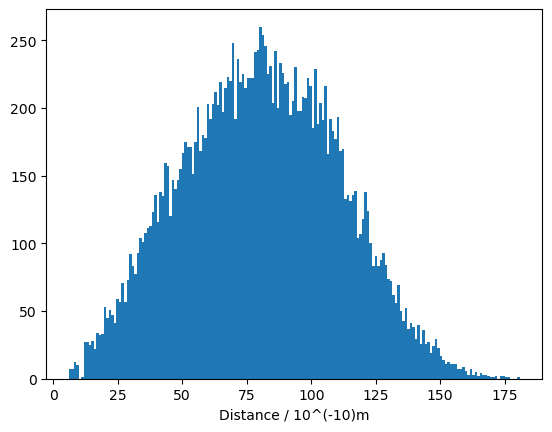

In [12]:
plt.figure(2)
plt.hist(distlog,bins=int(numpy.max(distlog)))
plt.xlabel('Distance / 10^(-10)m')


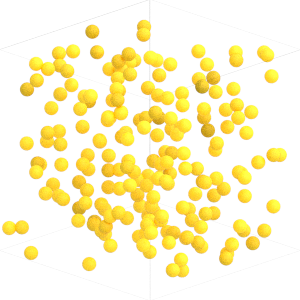

In [13]:
sf.render(sim.state.get_snapshot(),1.4*120+1)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  3.,  7., 11.,  9.,
         0.,  0.,  1., 26., 17., 20., 22.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ,  3.75,  4.5 ,  5.25,  6.  ,
         6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  , 12.75,
        13.5 , 14.25, 15.  ]),
 <BarContainer object of 20 artists>)

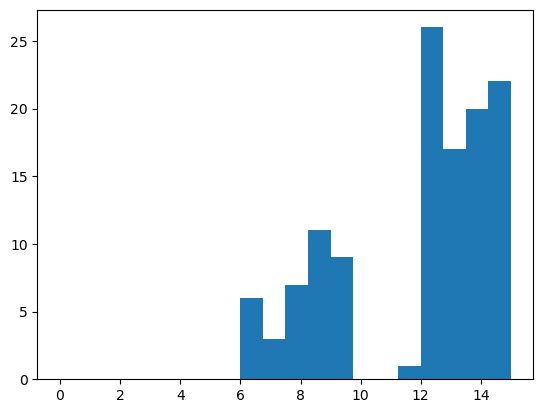

In [14]:
plt.figure(3)
plt.hist(distlog,bins=20,range=[0,15])